<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/Tsc_e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** ** **Tsc_Corrected and LST difference**

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 88.1 MB/s eta 0:00:00


# e_Tc calculation

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
years = list(range(2001, 2025))  # 2009 to 2016
seasons = [f"{s:02d}" for s in range(1, 5)]  # '01' to '04' for 4 seasons

lst_folder = '/content/drive/MyDrive/NEW FOLDER/NEWTRANING'
tsm_folder = '/content/drive/MyDrive/NEW FOLDER/TSM'
tn_folder = '/content/drive/MyDrive/NEW FOLDER/TN'
e_folder = '/content/drive/MyDrive/NEW FOLDER/E'
tc_folder = '/content/drive/MyDrive/NEW FOLDER/TC'
os.makedirs(e_folder, exist_ok=True)
os.makedirs(tc_folder, exist_ok=True)
# -----------------------------
# Load raster utility
# -----------------------------
def load_raster(path):
    with rasterio.open(path) as src:
        data = src.read(1).astype('float32')
        profile = src.profile
    return data, profile

# -----------------------------
# Save raster utility
# -----------------------------
def save_raster(output_path, data, profile):
    profile.update(dtype=rasterio.float32, count=1, compress='lzw')
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data.astype('float32'), 1)

# -----------------------------
# Processing loop
# -----------------------------
for year in years:
    for season in seasons:
        label = f"{year}_{season}"
        print(f"\nProcessing {label}...")

        # File paths
        lst_path = os.path.join(lst_folder, f"LST_{label}.tif")
        tsm_path = os.path.join(tsm_folder, f"Tsm_{label}.tif")
        tn_path = os.path.join(tn_folder, f"Tn_{label}.tif")

        # Check file existence
        if not all(os.path.exists(p) for p in [lst_path, tsm_path, tn_path]):
            print(f" Missing one or more files for {label}. Skipping...")
            continue

        # Load data
        LST, profile = load_raster(lst_path)
        Tsm, _ = load_raster(tsm_path)
        Tn, _ = load_raster(tn_path)

        # Compute intermediate variable and final prediction
        e = np.where(np.isfinite(LST) & np.isfinite(Tsm), LST - Tsm, np.nan)
        Tc = np.where(np.isfinite(Tn) & np.isfinite(e), Tn + e, np.nan)

        # Save results
        e_path = os.path.join(e_folder, f"e_{label}.tif")
        tc_path = os.path.join(tc_folder, f"Tc_{label}.tif")
        save_raster(e_path, e, profile)
        save_raster(tc_path, Tc, profile)

        print(f" Saved e to: {e_path}")
        print(f" Saved Tc to: {tc_path}")

      #  # --------------------------
      #  # Visualization of e (LST - Tsm)
      # # --------------------------
      #   plt.figure(figsize=(8, 6))
      #   plt.imshow(Tc, cmap='Spectral_r', vmin=275, vmax=310)
      #   plt.colorbar(label='LST - Tsm (K)')
      #   plt.title(f"Difference (e) for Season {label}")
      #   plt.axis('off')
      #   plt.tight_layout()
      #   plt.show()



Processing 2001_01...
 Saved e to: /content/drive/MyDrive/NEW FOLDER/E/e_2001_01.tif
 Saved Tc to: /content/drive/MyDrive/NEW FOLDER/TC/Tc_2001_01.tif

Processing 2001_02...
 Saved e to: /content/drive/MyDrive/NEW FOLDER/E/e_2001_02.tif
 Saved Tc to: /content/drive/MyDrive/NEW FOLDER/TC/Tc_2001_02.tif

Processing 2001_03...
 Saved e to: /content/drive/MyDrive/NEW FOLDER/E/e_2001_03.tif
 Saved Tc to: /content/drive/MyDrive/NEW FOLDER/TC/Tc_2001_03.tif

Processing 2001_04...
 Saved e to: /content/drive/MyDrive/NEW FOLDER/E/e_2001_04.tif
 Saved Tc to: /content/drive/MyDrive/NEW FOLDER/TC/Tc_2001_04.tif

Processing 2002_01...
 Saved e to: /content/drive/MyDrive/NEW FOLDER/E/e_2002_01.tif
 Saved Tc to: /content/drive/MyDrive/NEW FOLDER/TC/Tc_2002_01.tif

Processing 2002_02...
 Saved e to: /content/drive/MyDrive/NEW FOLDER/E/e_2002_02.tif
 Saved Tc to: /content/drive/MyDrive/NEW FOLDER/TC/Tc_2002_02.tif

Processing 2002_03...
 Saved e to: /content/drive/MyDrive/NEW FOLDER/E/e_2002_03.tif
 S

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.6 MB/s eta 0:00:00


# Trend plot

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.warp import transform
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter, MaxNLocator

# === CONFIGURATION ===
folder = "/content/drive/MyDrive/SEASON_DATA_SWAT/SEASONAL_TRENDS_TheilSen"
season_order = ['DJF', 'MAM', 'JJA', 'SON']
season_files = {season: os.path.join(folder, f'SWATI_{season}_TheilSen_slope.tif') for season in season_order}
utm_epsg = 'EPSG:32651'
wgs84_epsg = 'EPSG:4326'

# === Function to get lat/lon from transform ===
def get_latlon(profile):
    height, width = profile['height'], profile['width']
    transform_affine = profile['transform']
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(transform_affine, rows, cols)
    lon, lat = transform(utm_epsg, wgs84_epsg, np.array(xs).flatten(), np.array(ys).flatten())
    return np.array(lon).reshape(height, width), np.array(lat).reshape(height, width)

# === Format Functions ===
def format_lat(x, pos):
    return f"{abs(int(x))}°N"

def format_lon(x, pos):
    return f"{abs(int(x))}°E"

# === Load Rasters ===
season_data = []
latlon_info = []

for season in season_order:
    file = season_files[season]
    if not os.path.exists(file):
        raise FileNotFoundError(f"Missing: {file}")

    with rasterio.open(file) as src:
        data = src.read(1).astype(np.float32)
        data[data == src.nodata] = np.nan
        lon, lat = get_latlon(src.profile)
        season_data.append(data)
        latlon_info.append((lon, lat))

# === Plot Settings ===
fig, axes = plt.subplots(2, 2, figsize=(8, 10))
axes = axes.flatten()

cmap = ListedColormap(['lightgray', 'darkgreen'])  # 0 = not significant, 1 = significant
titles = {'DJF': 'Dec–Feb', 'MAM': 'Mar–May', 'JJA': 'Jun–Aug', 'SON': 'Sep–Nov'}

for i, season in enumerate(season_order):
    data = season_data[i]
    lon, lat = latlon_info[i]

    # Apply mask (only show where lon >= 120)
    mask = lon >= 120
    data = np.where(mask, data, np.nan)

    ax = axes[i]
    im = ax.pcolormesh(lon, lat, data, cmap=cmap, shading='auto', vmin=0, vmax=1)

    # Title
    ax.set_title(titles[season], fontsize=11, fontweight='bold')

    # Tick formatting
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(FuncFormatter(format_lon))
    ax.yaxis.set_major_formatter(FuncFormatter(format_lat))

    if i % 2 == 1:
        ax.set_yticklabels([])
    if i < 2:
        ax.set_xticklabels([])

    ax.set_xlim(left=120)

# === Adjust Layout and Add Horizontal Colorbar ===
fig.subplots_adjust(bottom=0.18, top=0.93, hspace=0.08, wspace=0.05)
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Not Significant', 'Significant'])
cbar.ax.tick_params(labelsize=10)
cbar.set_label("Mann-Kendall Trend Significance", fontsize=11)

# === Title ===
plt.suptitle("Seasonal Mann-Kendall Significance Maps (SWATI)", fontsize=13, fontweight='bold')

plt.show()


# visualization

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
years = list(range(2009, 2017))  # 2009 to 2016
seasons = [f"{s:02d}" for s in range(1, 5)]  # '01' to '04' for 4 seasons

lst_folder = '/content/drive/MyDrive/SEASON_II'
tsm_folder = '/content/drive/MyDrive/SEASON_II_TSM'
tn_folder = '/content/drive/MyDrive/SEASON_II_TN'
e_folder = '/content/drive/MyDrive/SEASON_DDII_E'
tc_folder = '/content/drive/MyDrive/SEASON_DDII_TC'
os.makedirs(e_folder, exist_ok=True)
os.makedirs(tc_folder, exist_ok=True)
# -----------------------------
# Load raster utility
# -----------------------------
def load_raster(path):
    with rasterio.open(path) as src:
        data = src.read(1).astype('float32')
        profile = src.profile
    return data, profile

# -----------------------------
# Save raster utility
# -----------------------------
def save_raster(output_path, data, profile):
    profile.update(dtype=rasterio.float32, count=1, compress='lzw')
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data.astype('float32'), 1)

# -----------------------------
# Processing loop
# -----------------------------
for year in years:
    for season in seasons:
        label = f"{year}_{season}"
        print(f"\nProcessing {label}...")

        # File paths
        lst_path = os.path.join(lst_folder, f"LST_{label}.tif")
        tsm_path = os.path.join(tsm_folder, f"Tsm_{label}.tif")
        tn_path = os.path.join(tn_folder, f"Tn_{label}.tif")

        # Check file existence
        if not all(os.path.exists(p) for p in [lst_path, tsm_path, tn_path]):
            print(f" Missing one or more files for {label}. Skipping...")
            continue

        # Load data
        LST, profile = load_raster(lst_path)
        Tsm, _ = load_raster(tsm_path)
        Tn, _ = load_raster(tn_path)

        # Compute intermediate variable and final prediction
        e = np.where(np.isfinite(LST) & np.isfinite(Tsm), LST - Tsm, np.nan)
        Tc = np.where(np.isfinite(Tn) & np.isfinite(e), Tn + e, np.nan)

        # Save results
        e_path = os.path.join(e_folder, f"e_{label}.tif")
        tc_path = os.path.join(tc_folder, f"Tc_{label}.tif")
        save_raster(e_path, e, profile)
        save_raster(tc_path, Tc, profile)

        print(f" Saved e to: {e_path}")
        print(f" Saved Tc to: {tc_path}")

        # --------------------------
        # Visualization
        # --------------------------
        plt.figure(figsize=(8, 6))
        plt.imshow(Tc, cmap='viridis',
                   vmin=np.nanpercentile(Tc, 2),
                   vmax=np.nanpercentile(Tc, 98))
        plt.colorbar(label='Predicted Tc (°C)')
        plt.title(f"Tc Prediction for Season {label}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()


# plotting e


📅 Processing Season 01...
 Season 01 color scale: vmin=-0.76, vmax=0.80


<ipython-input-5-ddd43247c801>:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


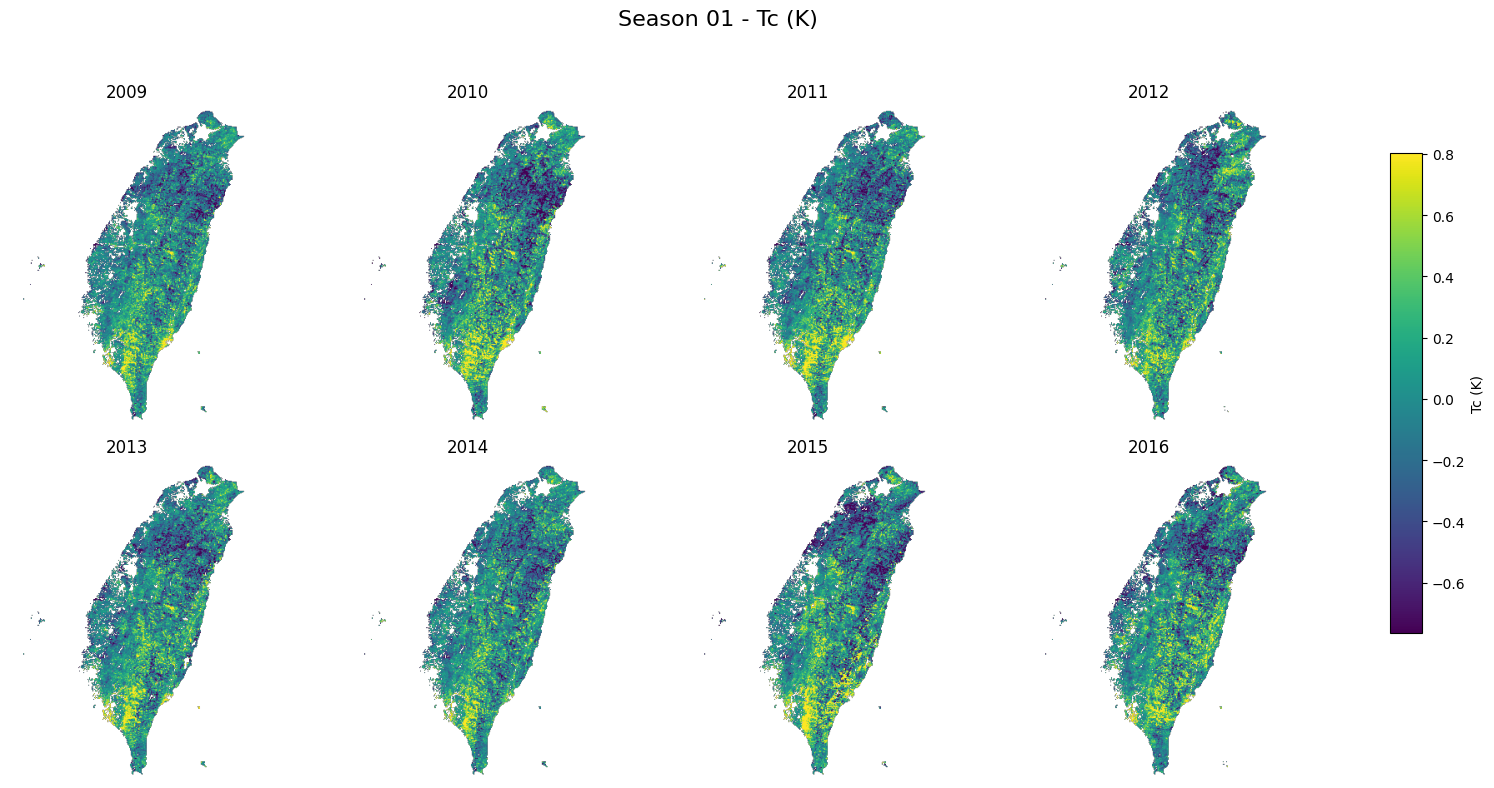


📅 Processing Season 02...
 Season 02 color scale: vmin=-0.88, vmax=0.91


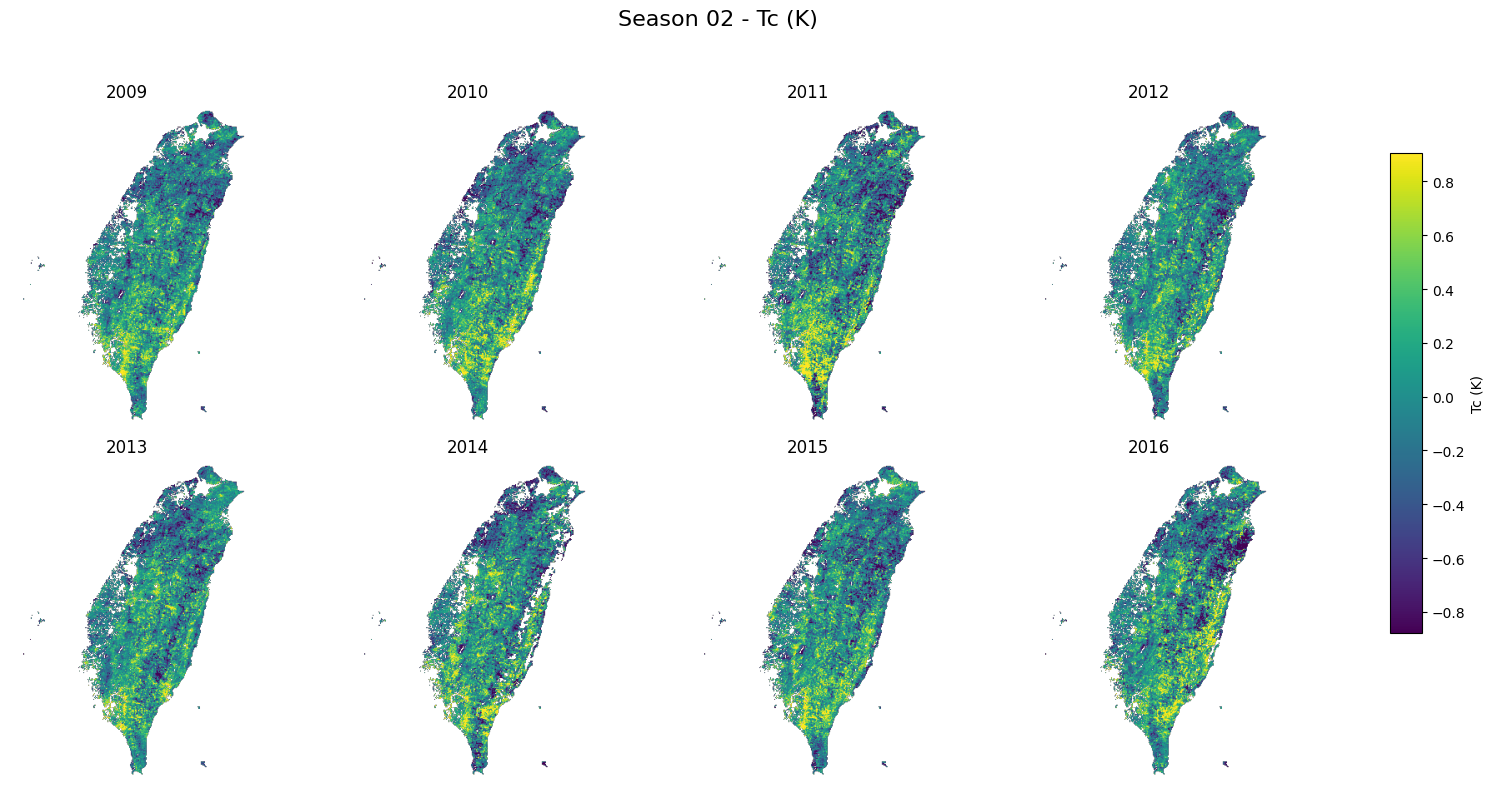


📅 Processing Season 03...
 Season 03 color scale: vmin=-0.82, vmax=0.79


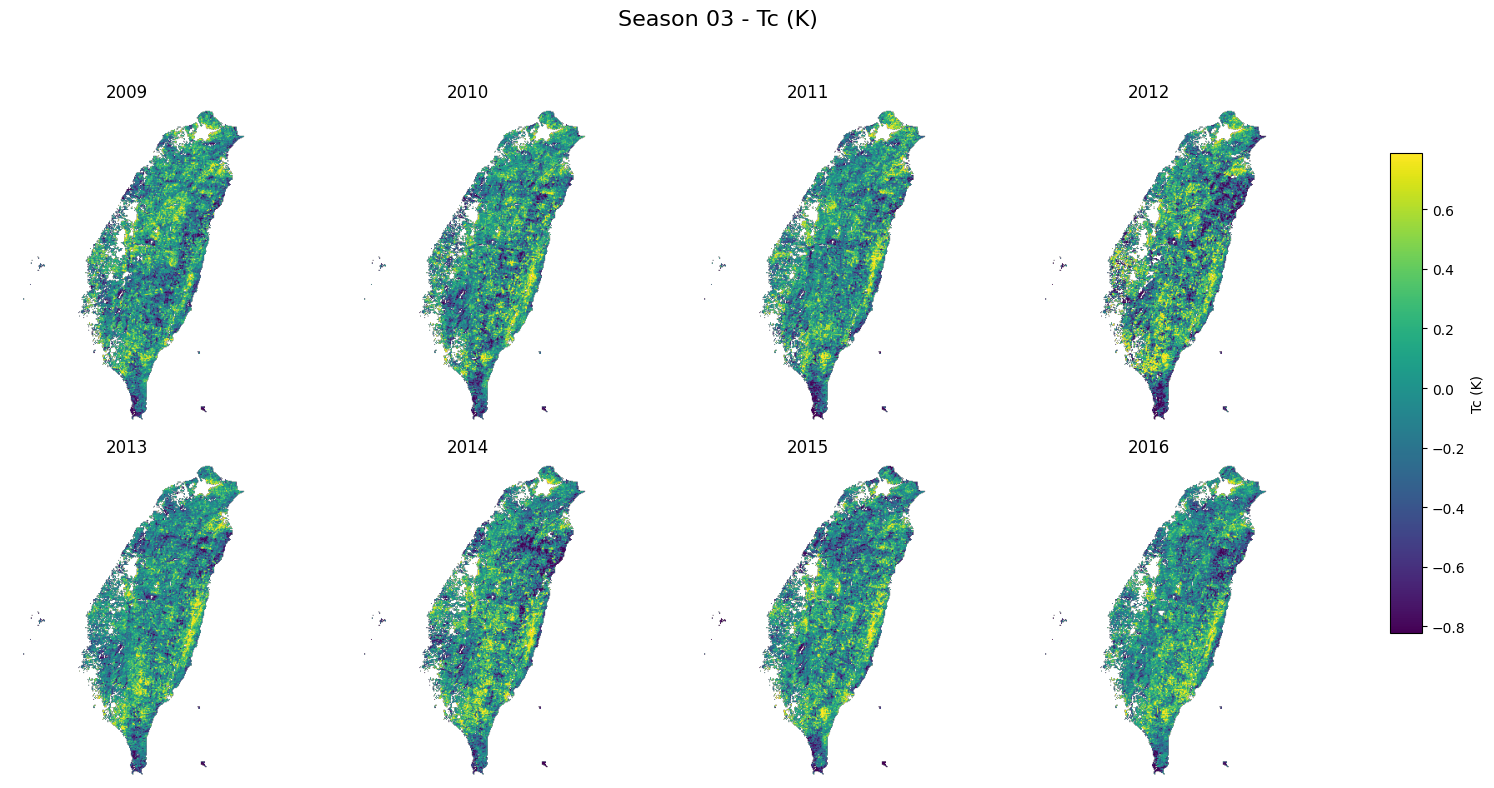


📅 Processing Season 04...
 Season 04 color scale: vmin=-0.78, vmax=0.74


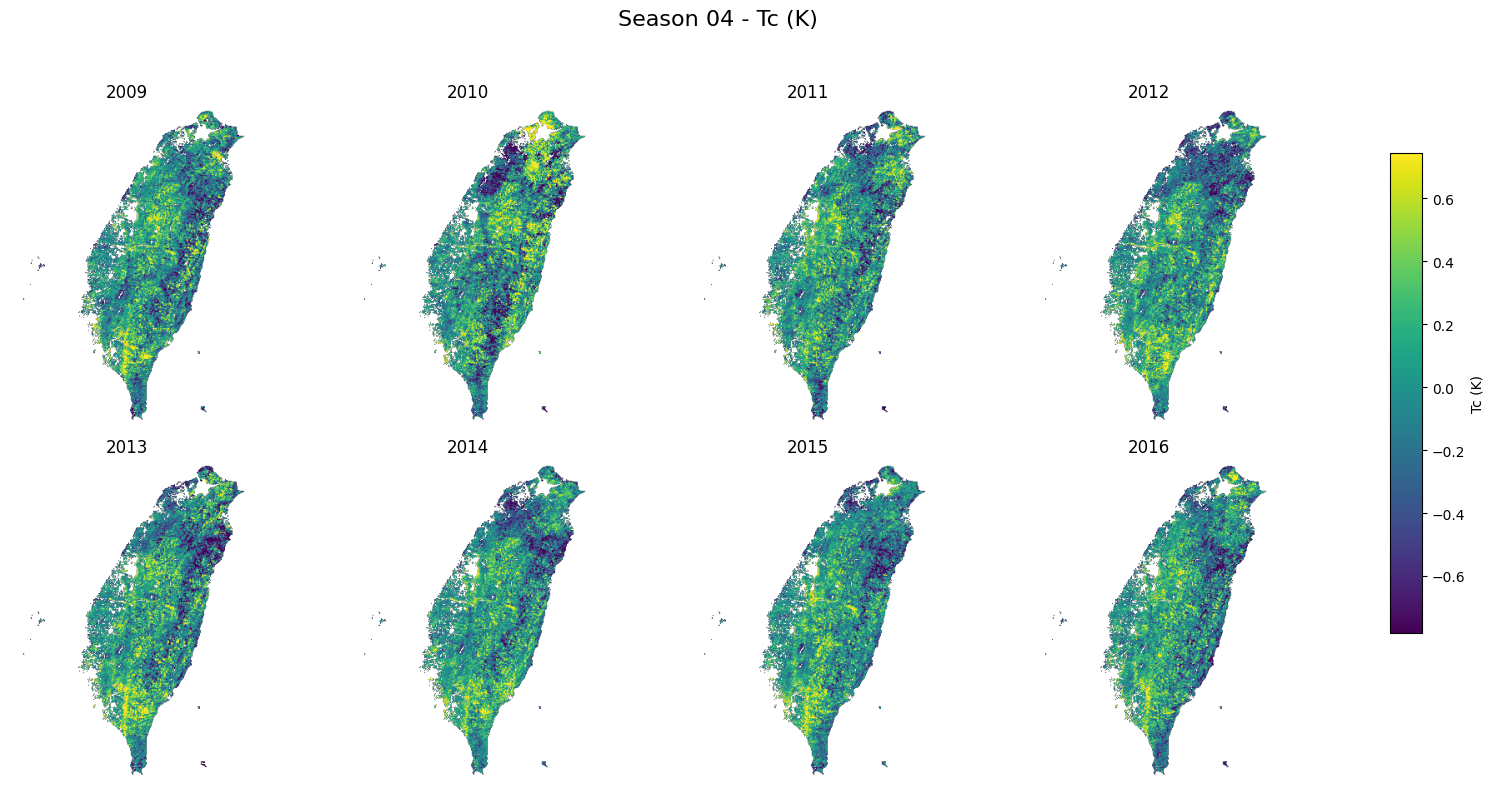

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Define the folder containing the Tc files
tc_folder = '/content/drive/MyDrive/SEASON_DATA_SWAT/SEASONAL_TRENDS_MK'

# Define years and seasons
years = list(range(2009, 2017))  # 2009 to 2016 inclusive
seasons = [f"{s:02d}" for s in range(1, 5)]  # '01', '02', '03', '04'

# Display grouped by season (with per-season global color scale)
for season in seasons:
    print(f"\n📅 Processing Season {season}...")

    season_pixels = []

    # Collect valid pixels for this season across all years
    for year in years:
        filename = f"e_{year}_{season}.tif"
        file_path = os.path.join(tc_folder, filename)
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read(1).astype('float32')
                valid = data[np.isfinite(data)]
                if valid.size > 0:
                    season_pixels.append(valid)
        else:
            print(f" File not found: {filename}")

    if not season_pixels:
        print(f"No valid data found for season {season}")
        continue

    # Compute per-season color scale
    all_values = np.concatenate(season_pixels)
    vmin = np.percentile(all_values, 2)
    vmax = np.percentile(all_values, 98)
    print(f" Season {season} color scale: vmin={vmin:.2f}, vmax={vmax:.2f}")

    # Plot maps for each year in this season
    ncols = 4
    nrows = int(np.ceil(len(years) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows))

    for idx, year in enumerate(years):
        filename = f"e_{year}_{season}.tif"
        file_path = os.path.join(tc_folder, filename)

        row, col = divmod(idx, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]

        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read(1)
            if np.all(np.isnan(data)):
                ax.set_title(f"{year}: Empty")
                ax.axis('off')
            else:
                img = ax.imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
                ax.set_title(f"{year}")
                ax.axis('off')
        else:
            ax.set_title(f"{year}: Missing")
            ax.axis('off')

    # Hide any unused subplots
    for ax in axes.flat[len(years):]:
        ax.axis('off')

    fig.suptitle(f"Season {season} - Tc (K)", fontsize=16)
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(img, cax=cbar_ax, label='Tc (K)')
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()


# Ploting Tc

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Define the folder containing the Tc files
tc_folder = '/content/drive/MyDrive/SEASON_THREE_TC'

# Define years and seasons
years = list(range(2017, 202024))  # 2009 to 2016 inclusive
seasons = [f"{s:02d}" for s in range(1, 5)]  # '01', '02', '03', '04'

# Display grouped by season (with per-season global color scale)
for season in seasons:
    print(f"\n📅 Processing Season {season}...")

    season_pixels = []

    # Collect valid pixels for this season across all years
    for year in years:
        filename = f"Tc_{year}_{season}.tif"
        file_path = os.path.join(tc_folder, filename)
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read(1).astype('float32')
                valid = data[np.isfinite(data)]
                if valid.size > 0:
                    season_pixels.append(valid)
        else:
            print(f" File not found: {filename}")

    if not season_pixels:
        print(f"No valid data found for season {season}")
        continue

    # Compute per-season color scale
    all_values = np.concatenate(season_pixels)
    vmin = np.percentile(all_values, 2)
    vmax = np.percentile(all_values, 98)
    print(f" Season {season} color scale: vmin={vmin:.2f}, vmax={vmax:.2f}")

    # Plot maps for each year in this season
    ncols = 2
    nrows = int(np.ceil(len(years) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows))

    for idx, year in enumerate(years):
        filename = f"Tc_{year}_{season}.tif"
        file_path = os.path.join(tc_folder, filename)

        row, col = divmod(idx, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]

        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read(1)
            if np.all(np.isnan(data)):
                ax.set_title(f"{year}: Empty")
                ax.axis('off')
            else:
                img = ax.imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
                ax.set_title(f"{year}")
                ax.axis('off')
        else:
            ax.set_title(f"{year}: Missing")
            ax.axis('off')

    # Hide any unused subplots
    for ax in axes.flat[len(years):]:
        ax.axis('off')

    fig.suptitle(f"Season {season} - Tc (K)", fontsize=16)
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(img, cax=cbar_ax, label='Tc (K)')
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()
